## Google Colab Setup

In [36]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [37]:
COLAB = False

import os
import sys

dataset = "flickr30k"

if COLAB:
    
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)

    GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = "CIS583/Project/"
    assert GOOGLE_DRIVE_PATH_AFTER_MYDRIVE is not None
    GOOGLE_DRIVE_PATH = os.path.join('drive', 'MyDrive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
    print(os.listdir(GOOGLE_DRIVE_PATH))
    print(GOOGLE_DRIVE_PATH)

    sys.path.append(GOOGLE_DRIVE_PATH)
    print(sys.path)

    # Define the dataset directory
    dataset_root_dir = os.path.join(GOOGLE_DRIVE_PATH, dataset)
    captions_file_path = os.path.join(dataset_root_dir, "cleaned_captions.txt")

else:

    dataset_root_dir = os.path.join(os.getcwd(), dataset)
    captions_file_path = os.path.join(dataset_root_dir, "cleaned_captions.txt")


## Flickr data loading

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9843137].


a brown dog bares its fangs


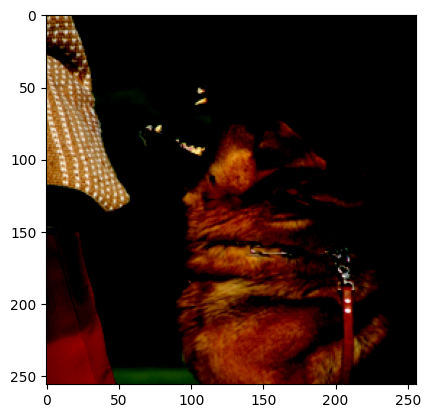

In [38]:
import warnings
warnings.filterwarnings('ignore')

from data import flickr_dataset
from transformers import CLIPTokenizer
from torchvision import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import PIL as Image
import random
import os
import torch

# define transforms for dataset
image_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# define CLIP tokenizer
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-base-patch32")

dataset = flickr_dataset.FlickrDataset(dataset_root_dir, captions_file_path, image_transforms, tokenizer)
dataloader = DataLoader(dataset, batch_size = 32, shuffle=True)

# display dataset example
image, caption = dataset[random.randint(0, len(dataset))]
print(tokenizer.decode(caption, skip_special_tokens=True))
plt.imshow(image.permute(1, 2, 0))
plt.show()

## Define text encoder

In [39]:
from transformers import CLIPTextModel, CLIPTokenizer

tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-base-patch32")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-base-patch32")

def encode_text(captions):
    tokens = tokenizer(captions, padding=True, truncation=True, return_tensors="pt")
    embeddings = text_encoder(**tokens).last_hidden_state
    return embeddings.mean(dim=1)  # Aggregate embeddings


## Training Attention Based Conditional LDM

In [40]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from models import autoencoder, diffusion
from models import unet
from tqdm import tqdm
import numpy as np

# Parameters
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu") # for mac gpu

latent_dim = 64
text_embed_dim = 512
epochs = 10
learning_rate = 1e-4
save_dir = "checkpoints"

# Create directories
os.makedirs(save_dir, exist_ok=True)

# Models
encoder = autoencoder.Encoder(latent_dim).to(device)
decoder = autoencoder.Decoder(latent_dim).to(device)
unet = unet.UNet(latent_dim, text_embed_dim).to(device)
diffusion = diffusion.Diffusion(noise_schedule=torch.linspace(0.01, 0.1, 1000), device=device).to(device)

# To train from previous checkpoint
checkpoint = torch.load(os.path.join(save_dir, "model_epoch_20.pth"))
encoder.load_state_dict(checkpoint['encoder'])
decoder.load_state_dict(checkpoint['decoder'])
unet.load_state_dict(checkpoint['unet'])

# Loss and Optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(
list(encoder.parameters()) + list(decoder.parameters()) + list(unet.parameters()), lr=learning_rate)

In [42]:
show_image = False 

# Training Loop
for epoch in range(epochs):
    encoder.train()
    decoder.train()
    unet.train()
    total_loss = 0

    # To store latents for debugging
    forward_latent_representations = []
    reverse_latent_representations = []

    for batch_idx, (images, captions) in enumerate(tqdm(dataloader)):
        images = images.to(device)
        # Convert captions tensor to a list of strings
        captions = [dataset.tokenizer.decode(caption, skip_special_tokens=True) for caption in captions]
        # captions = captions.to(device)

        # Encode text
        # print(captions)
        text_embedding = encode_text(captions).to(device)

        # Encode images
        latent = encoder(images)

        # Forward Diffusion
        t = torch.randint(0, 1000, (images.size(0),)).to(device)
        noisy_latent = diffusion.forward_diffusion(latent, t=t)

        # U-Net prediction
        predicted_noise = unet(noisy_latent, text_embedding)

        # Reverse diffusion
        recovered_latent = diffusion.reverse_diffusion(noisy_latent, t=t, predicted_noise=predicted_noise)

        # Decode back to image
        reconstructed_image = decoder(recovered_latent)

        if show_image:
            print(captions[0])
            image_np = images[0].cpu().permute(1, 2, 0).detach().numpy()
            image_np = (image_np * 255).astype(np.uint8)
            recon_image_np = reconstructed_image[0].cpu().permute(1, 2, 0).detach().numpy()
            recon_image_np = (recon_image_np * 255).astype(np.uint8)
            plt.imshow(image_np)
            plt.show()
            plt.imshow(recon_image_np)
            plt.show()
            show_image = False

        # Loss
        loss = criterion(reconstructed_image, images)
        total_loss += loss.item()

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # print("Batch: {}".format(batch_idx))
        # print("Loss for current batch: {}".format(loss))

    # Log progress
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss / len(dataloader):.4f}")

    if (epoch+1)%10 == 0:
        # Save checkpoint
        torch.save({
            'encoder': encoder.state_dict(),
            'decoder': decoder.state_dict(),
            'unet': unet.state_dict()
        }, os.path.join(save_dir, f"model_epoch_{epoch + 11}.pth"))

print("Training complete!")

100%|██████████| 4967/4967 [1:24:29<00:00,  1.02s/it]


Epoch 1/10, Loss: 0.0025


100%|██████████| 4967/4967 [1:45:42<00:00,  1.28s/it]   


Epoch 2/10, Loss: 0.0022


100%|██████████| 4967/4967 [1:23:18<00:00,  1.01s/it]


Epoch 3/10, Loss: 0.0020


100%|██████████| 4967/4967 [1:21:02<00:00,  1.02it/s]


Epoch 4/10, Loss: 0.0018


100%|██████████| 4967/4967 [1:20:40<00:00,  1.03it/s]


Epoch 5/10, Loss: 0.0017


100%|██████████| 4967/4967 [1:24:32<00:00,  1.02s/it]


Epoch 6/10, Loss: 0.0016


100%|██████████| 4967/4967 [1:22:39<00:00,  1.00it/s]


Epoch 7/10, Loss: 0.0015


100%|██████████| 4967/4967 [1:22:07<00:00,  1.01it/s]


Epoch 8/10, Loss: 0.0014


100%|██████████| 4967/4967 [1:21:59<00:00,  1.01it/s]


Epoch 9/10, Loss: 0.0014


100%|██████████| 4967/4967 [1:24:21<00:00,  1.02s/it]


Epoch 10/10, Loss: 0.0013
Training complete!


## Test the trained model to generate image with caption

Encoder(
  (conv): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  )
)
Decoder(
  (deconv): Sequential(
    (0): ConvTranspose2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): Tanh()
  )
)
UNet(
  (down1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (down2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (attn): CrossAttention(
    (attention): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
    )
    (latent_proj): Conv2d(128, 512, ker

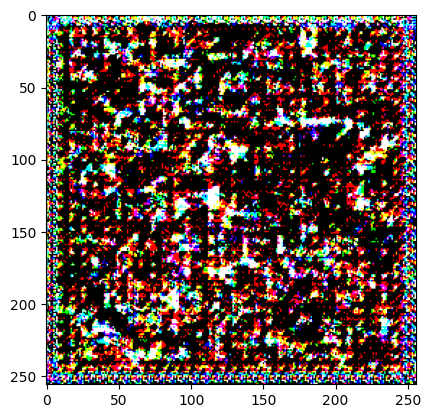

In [46]:
import numpy as np

# Load the saved model
save_dir = "checkpoints"
checkpoint = torch.load(os.path.join(save_dir, "model_epoch_20.pth"))

# Load the state dictionaries into the models
encoder.load_state_dict(checkpoint['encoder'])
decoder.load_state_dict(checkpoint['decoder'])
unet.load_state_dict(checkpoint['unet'])

print(encoder)
print(decoder)
print(unet)

# Set the models to evaluation mode
encoder.eval()
decoder.eval()
unet.eval()

def generate_image(caption, num_steps=1000):
    with torch.no_grad():
        text_embedding = encode_text([caption]).to(device)
        latent_noise = torch.randn((1, latent_dim, 32, 32)).to(device)
        # t = torch.randint(0, 1000, (images.size(0),)).to(device)
        # latent_noise = diffusion.forward_diffusion(latent, t=t)

        for t in reversed(range(num_steps)):
            predicted_noise = unet(latent_noise, text_embedding)
            latent_noise = diffusion.reverse_diffusion(latent_noise, t, predicted_noise)

        return decoder(latent_noise)

# Test
generated_image = generate_image("dog")

# Convert the tensor to a numpy array
image_np = generated_image.cpu().numpy().squeeze(0).transpose(1, 2, 0)

image_np = (image_np * 255).astype(np.uint8)

# Display the image
plt.imshow(image_np)
plt.axis('on')
plt.show()


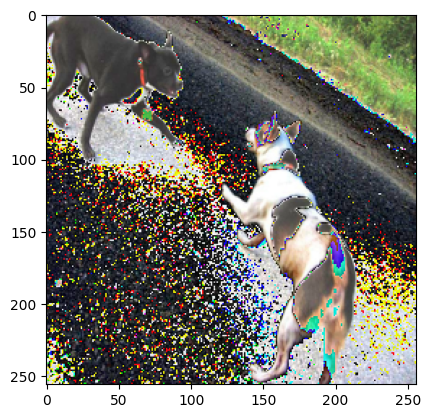

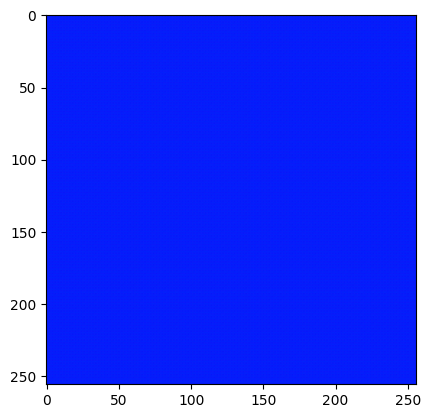

In [ ]:
from torch.nn import functional as F
import torch.nn as nn

test_image, test_caption = dataset[5]

class UNet(nn.Module):
    def __init__(self, latent_dim):
        super(UNet, self).__init__()
        self.down1 = nn.Conv2d(latent_dim, 64, kernel_size=3, padding=1)
        self.down2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.down3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        # self.attn = CrossAttention(embed_dim=text_embed_dim)  # Use text_embed_dim here
        # self.reduce_channels = nn.Conv2d(text_embed_dim, 128, kernel_size=1)
        self.up1 = nn.ConvTranspose2d(256, 128, kernel_size=3, padding=1)
        self.up2 = nn.ConvTranspose2d(128, 64, kernel_size=3, padding=1)
        self.up3 = nn.ConvTranspose2d(64, latent_dim, kernel_size=3, padding=1)

    def forward(self, x):
        x = F.relu(self.down1(x))
        x = F.relu(self.down2(x))
        # x = F.relu(self.down3(x))
        # x = self.attn(x, text_embedding)
        # x = self.reduce_channels(x)
        # x = F.relu(self.up1(x))
        x = F.relu(self.up2(x))
        return self.up3(x)
    
test_in_latent = encoder(test_image.to(device))
unet = UNet(latent_dim).to(device)
unet.eval()
test_out_latent = unet(test_in_latent)
test_out_image = decoder(test_out_latent)

in_image_np = test_image.permute(1, 2, 0).cpu().numpy()
in_image_np = (in_image_np * 255).astype(np.uint8)

out_image_np = test_out_image.cpu().detach().numpy().transpose(1, 2, 0)
out_image_np = (out_image_np * 255).astype(np.uint8)

plt.imshow(in_image_np)
plt.show()
plt.imshow(out_image_np)
plt.show()
